# Tree-based Methods (MACS 30100)
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), February 2018
The code in this Jupyter notebook was written using Python 3.6. It uses data files [`Titanic dataset`](https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv). For the code to run properly, you will either need to have access to the internet or you should have the data file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data to reflect the location of that data.

This notebook follows some of the material in James, et al (2013, Ch. 8). Everything in this notebook will build to the methods of Random Forests and Boosting. But it is helpful to talk about the intermediate models to build up the intuitoin for the more complex models. We will cover:

1. Basic decision trees
2. Bagging
3. Random Forests
4. Boosting

## 1. Basic decision trees
The documentation for [`scikit-learn`'s decision tree libraries](http://scikit-learn.org/stable/modules/tree.html) states, "Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features." Figures 8.1 and 8.2 from James, et al (2013) shows a basic three-region, three-leaf, three partition decision tree for the `Hitters` data from the book used to predict a professional baseball player's salary. Each partition represents a terminal node of the tree, or a leaf. The points along the ree where the predictor space is split are referred to as internal nodes. The segments that connect the nodes are called branches.

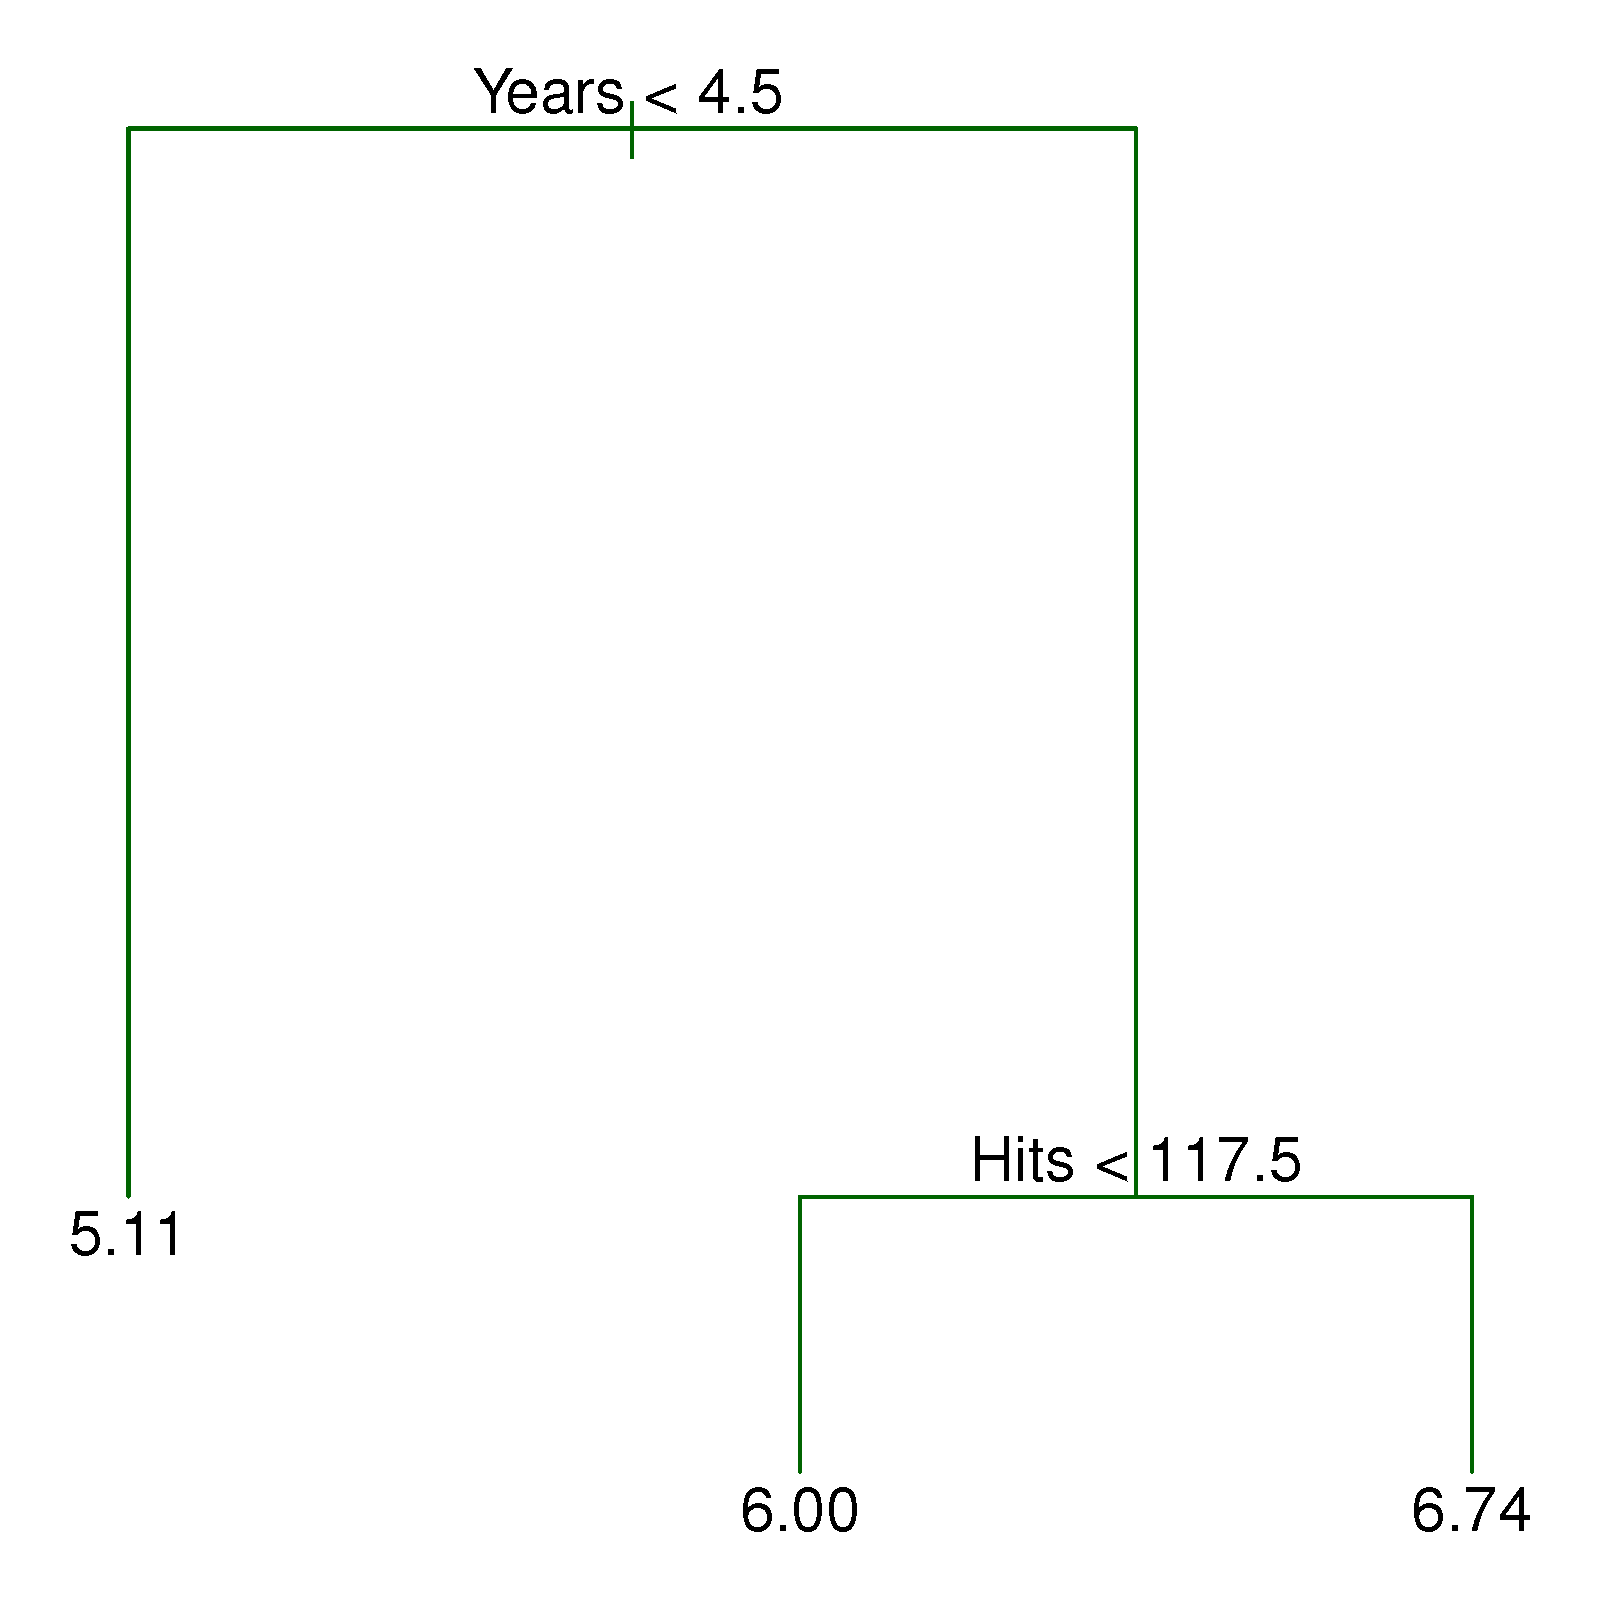

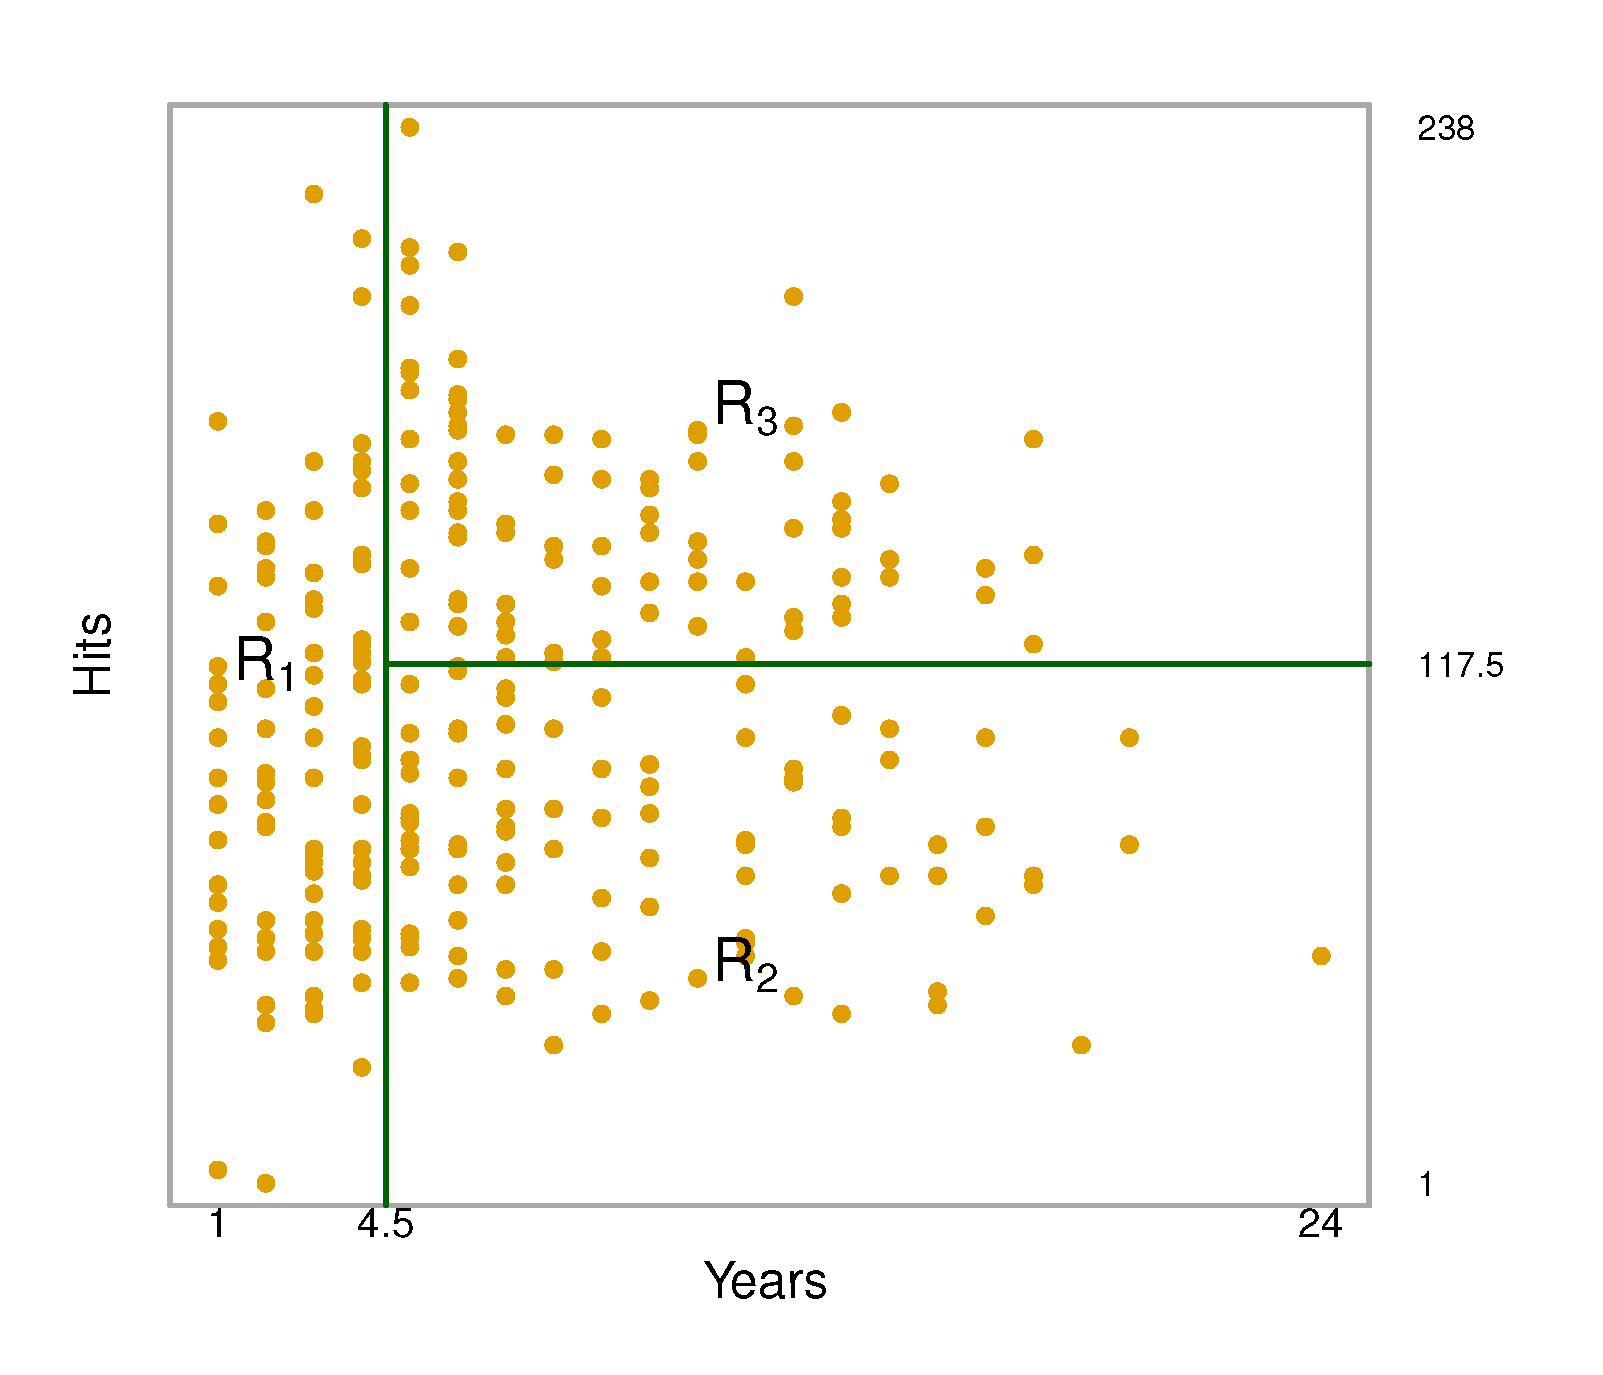

The three regions are $R_1 = \{Y_i|Years_i<4.5\}$, $R_2 = \{Y_i|Years_i\geq 4.5 \: \& \: Hits_i<117.5\}$, and $R_3 = \{Y_i|Years_i\geq 4.5 \: \& \: Hits_i\geq 117.5\}$.

More generally, to predict $Y$ using tree based methods:

1. Choose how many $P$ predictors to use in the feature space $X_1, X_2,... X_P$,
2. Divide the feature space into $J$ mutually exclusive regions $R_1, R_2,... R_J$,
3. For $Y_i\in R_j$, predict mean value $Y_i= \frac{1}{N_j}\sum_{k=1}^{N_j}Y_i$.

### 1.1. Regression trees
Regression trees are trees in which the predicted values at the leaves or terminal nodes are continuous variable values. The predicted salaries from the `Hitters` baseball wage data is the average salary in each region.

* $R_1 = \{X_i|Years_i<4.5\} = \$1,000 \times e^{5.107} \approx \$165,174 $
* $R_2 = \{X_i|Years_i\geq 4.5 \: \& \: Hits_i<117.5\} = \$1,000 \times e^{5.999} \approx \$402,834 $
* $R_3 = \{X_i|Years_i\geq 4.5 \: \& \: Hits_i\geq 117.5\} = \$1,000 \times e^{6.740} \approx \$845,346 $

**Four key questions**
1. How do we choose which feature variables to use?
2. How do we choose the cutoffs or bifurcation points for each node (e.g., $Years_i<4.5$)?
3. How do we choose which features or variables are at the base of the tree and which ones are at the ends of the branches?
4. How do we measure accuracy and fit?

Let's start with the last question (4). The structure of a decision tree--feature variables, cutoffs, and order of appearance--is chosen to minimize the residual sum of squares $RSS$ of a training data set.

$$ RSS = \sum_{j=1}^J\sum_{i\in R_j}\left(y_i - \hat{y}_i\right)^2 $$

But, as with the linear regression methods and classification methods of earlier notebooks, the accuracy of the model is measured by the MSE and estimated error rate of the model on a test set. 

The answer to question (1) is up to the modeler. The cutoff/bifurcation points (2) and the order in which the variables apear in the tree from the base to the leaves (3) are chosen to minimize the RSS. We can use *recursive binary splitting* to choose the cutoff or bifurcation points of each node.

1. Solve for the predictor $X_j$ and cutoff\bifurcation $t_j$ that gives the lowest RSS in the training set. Any $X_j$ and $t_j$ divides the space into two half-planes $R_1(j,t_j)=\{X|X_j<t_j\}$ and $R_2(j,t_j)=\{X|X_j<t_j\}$. We seek the variable $X_j$ and cutoff $t_j$ that minimmize the RSS. This must be done by solving for the optimal cutoff $t_j$ for each $X_j$.

$$ (X_1, t_1) = (X_j, t_j): \quad \min_{(X_j, t_j)}\sum_{x_i\in R_1(j,t_j)}\left(y_i -\hat{y}_i\right)^2 + \sum_{x_i\in R_2(j,t_j)}\left(y_i -\hat{y}_i\right)^2 $$

2. Solve for the best predictor on each branch of the previously optimized variable by cycling through each feature $X_j$ and solving for the one in each branch with the minimum RSS.

3. Continue this process until a stopping criterion is reached (e.g., no region contains more than 5 observations.

Figure 8.3 from James, et al (2013) shows a five-region example.

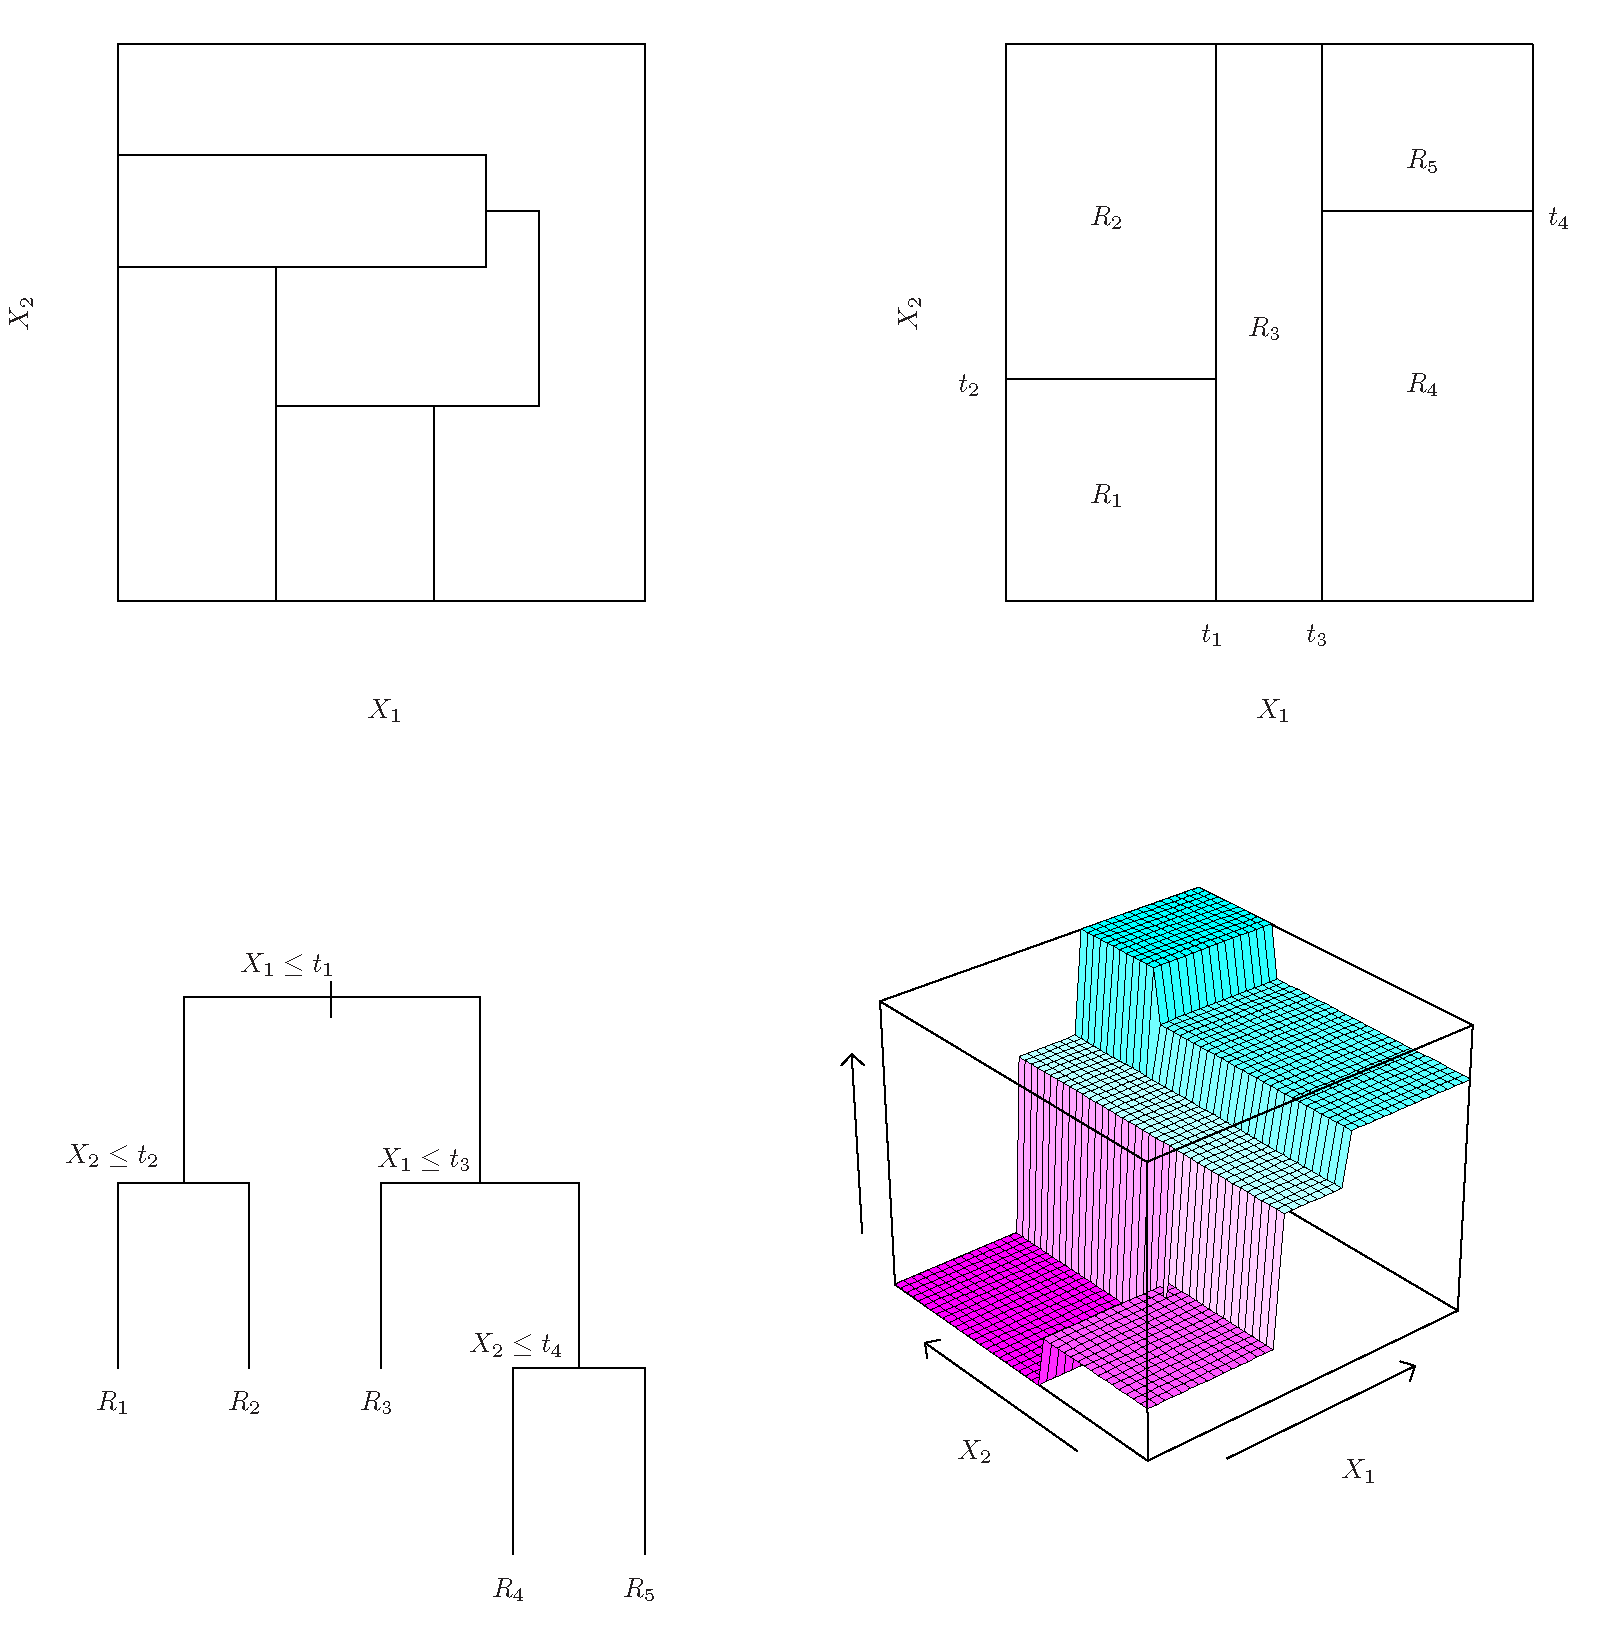

In [ ]:
# Install the open source GraphViz program using
# conda install python-graphviz

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

hitters = pd.read_csv('Hitters.csv', sep=',')
# Drop observations with NaN in Salary
hitters = hitters.dropna()
print(hitters.head())
y = hitters['Salary'].values
X = hitters[['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks',
             'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns',
             'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']].values
print(hitters.info())

In [ ]:
hit_tree = DecisionTreeRegressor(max_depth=5)
hit_tree.fit(X, y)

In [ ]:
hit_tree_viz = export_graphviz(
    hit_tree,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz)
graph.render('hit_tree_viz')
graph

Now let's take the validation set approach to cross validation, break the data into training set and test set, and test the MSE of our predictor.

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4,
                                                    random_state=25)
hit_tree2 = DecisionTreeRegressor(max_depth=5)
hit_tree2.fit(X_train, y_train)

In [ ]:
hit_tree_viz2 = export_graphviz(
    hit_tree2,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz2)
graph.render('hit_tree_viz2')
graph

In [ ]:
y_pred = hit_tree2.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print('MSE=', MSE)

### 1.2. Tree pruning
Recursive binary splitting provides the best fit on the training set, but is likely to overfit the data and perform poorly in terms of prediction and error rate on a test set. Analogous to what we saw in the classification and regression examples, a smaller tree might predict better on a test set. Furthermore, the number of samples in a terminal node or leaf should be greater than 1.

Similar to adjusted $R$-squared and similar to lasso regression, we can use a tuning parameter $\alpha\in[0,1]$ that limits the number of branches on each tree by including a penalty to the RSS fit criterion that penalizes $|T|$ the number of terminal nodes on tree $T$. For each value of $\alpha$ there corresponds an optimal subtree $T\subset T_0$ such that:

$$ \sum_{m=1}^{|T|}\sum_{X_i\in R_m} \left(y_i - \hat{y}_i\right)^2 + \alpha|T| $$

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.
3. Use $K$-fold cross validation ot choose $\alpha$.
4. Return the subtree from Step 2 that corresponds to the chose value of $\alpha$

This pruning currently must be coded by hand in Python. That is, `scikit-learn` does not have automatic pruning mechanisms. However, the justification is that effective pruning can be done by manipulating the parameters `max_depth`, `min_impurity_split`, `min_samples_leaf` and `min_samples_split`.

### 1.3 Classification trees
A classification tree is a decision tree that has a categorical variable as the outcome variables. For a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs. The classification error rate is simply the fraction of training observations in that region that do not belong to the most common class.

$$ ErrorRate = 1 - \max_{k}\left(\hat{p}_{m,k}\right) $$

However, classification error rate is not sensitive enough for growing trees. That is, it does not change for small changes in cutoff. For this reason, classification tree building uses either the *Gini index* or the *Entropy index* instead of the error rate.

$$ Gini = \sum_{k=1}^K \hat{p}_{m,k}\left(1 - \hat{p}_{mk}\right) $$

$$ Entropy = -\sum_{k=1}^K \hat{p}_{m,k}\ln\left(\hat{p}_{mk}\right) $$

Both the Gini index and the entropy are measures of node purity. They have values close to 0 if most of the samples in the node are in a single class (low variance) and they will both take on higher values closer to 1 if the samples in the node are in many different classes (high variance).

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

iris_tree = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(iris_tree)
graph.render('iris')
graph

## 2. Bagging (Bootstrapping)

## 3. Random Forests

## 4. Boosting

## References
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, [*An Introduction to Statistical Learning with Applications in R*](http://link.springer.com.proxy.uchicago.edu/book/10.1007%2F978-1-4614-7138-7), New York, Springer (2013).